In [1]:

import gym
from collections import deque
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from stable_baselines3 import DQN, PPO, A2C
import pygame
import threading
import time
import gym
from gym import spaces
import numpy as np
import pygame
import gym
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import random
import matplotlib.pyplot as plt
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))  # Convert states to numpy arrays for storage

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)

        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        
        return torch.FloatTensor(state), torch.LongTensor(action), torch.FloatTensor(reward), torch.FloatTensor(next_state), torch.FloatTensor(done)

class PongEnvironment(gym.Env):
    def __init__(self):
        super(PongEnvironment, self).__init__()
        self.width = 400
        self.height = 300
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array([self.width // 2, random.randint(0,self.height) // 2], dtype=float)
        self.ball_vel = np.array([5, 1], dtype=float) * 100
        self.paddle_pos = self.height // 2
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def reset(self):
        self.time_step=0
        self.start_time=time.time()
        self.tot_reward=0
        self.ball_pos = np.array([self.width // 2, self.height // random.randrange(1,10)], dtype=float)
        self.ball_vel = np.array([random.random(), random.random()], dtype=float) * 100
        self.paddle_pos = self.height // 2
        return self.get_state()

    def step(self, action):
        
        self.time_step+=1
        if action == 0:
            move = -5
        else:
            move = 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel

        if (
            self.ball_pos[1] <= self.ball_radius
            or self.ball_pos[1] >= self.height - self.ball_radius
        ):
            self.ball_vel[1] *= -1

        reward = 0
        done = False

        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if (
                self.paddle_pos - self.paddle_height / 2
                <= self.ball_pos[1]
                <= self.paddle_pos + self.paddle_height / 2
            ):
                self.ball_vel[0] *= -1
                reward = 1
                self.tot_reward+=1
            else:
                reward = 0
                done = True
        if self.tot_reward>10 or time.time()-self.start_time>30:
            if self.tot_reward>10:
                print('xxx')
            done = True
        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return self.get_state(), reward, done, {}

    def move_paddle(self, move):
        self.paddle_pos = np.clip(
            self.paddle_pos + move,
            self.paddle_height / 2,
            self.height - self.paddle_height / 2,
        )

    def get_state(self):
        return np.array(
            [
                self.ball_pos[0] / self.width,
                self.ball_pos[1] / self.height,
                self.ball_vel[0] / 100,
                self.ball_vel[1] / 100,
                self.paddle_pos / self.height,
            ]
        )

    def render(self, mode="rgb_array"):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(
            self.screen,
            (255, 255, 255),
            pygame.Rect(
                0,
                int(self.paddle_pos - self.paddle_height / 2),
                self.paddle_width,
                self.paddle_height,
            ),
        )
        pygame.draw.circle(
            self.screen,
            (255, 255, 255),
            (int(self.ball_pos[0]), int(self.ball_pos[1])),
            self.ball_radius,
        )
        pygame.display.update()

        if mode == "rgb_array":
            data = pygame.surfarray.array3d(pygame.display.get_surface())
            return np.transpose(data, (1, 0, 2))
        return np.transpose(data, (1, 0, 2))


class DQNAgent:
    def __init__(self, env):
        self.model = DQN("MlpPolicy", env, verbose=1)
        self.env=env

    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done and episode_reward<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward
            total_rewards += episode_reward
            # print(episode_reward)
            total_rewards_list.append(episode_reward)
            
        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


class PPOAgent:
    def __init__(self, env):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.env=env


    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done and total_rewards<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward

            total_rewards += episode_reward
            # print(episode_reward)
            total_rewards_list.append(episode_reward)
            print(zz)
            
        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


class A2CAgent:
    def __init__(self, env):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.env=env

    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
        
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done and episode_reward<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward

            total_rewards += episode_reward
            print(episode_reward)
            total_rewards_list.append(episode_reward)
            print(zz)
            
        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


env = DummyVecEnv([lambda: PongEnvironment()])

dqn_agent = DQNAgent(env)
ppo_agent = PPOAgent(env)
a2c_agent = A2CAgent(env)


total_timesteps = 100000
# dqn_agent.train(total_timesteps)
# ppo_agent.train(total_timesteps)
# a2c_agent.train(total_timesteps)


dqn_agent.model = DQN.load('./dqn.zip')
ppo_agent.model = PPO.load('./ppo.zip')
a2c_agent.model = A2C.load('./a2c.zip')



expert_agents=[dqn_agent,ppo_agent,a2c_agent]
expert_agents_2=[ppo_agent,dqn_agent]


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Using cpu device
Using cpu device


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


In [ ]:

import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pygame



class PongEnvironment:
    def __init__(self, width=400, height=300):
        self.width = width
        self.height = height
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array([self.width // 2, random.randint(0,self.height) // 2], dtype=float)
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = random.randint(0,self.height)
        self.screen = pygame.display.set_mode((self.width, self.height))

    def reset(self):
        self.start_time=time.time()
        self.total_reward=0
        self.ball_pos = np.array([self.width // 2, random.randint(0,self.height)], dtype=float)
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = random.randint(0,self.height)
        return torch.FloatTensor(self.get_state())

    def step(self, action):
        if action == 0:  # Move up
            move = -5
        else:  # Move down
            move = 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel

        if self.ball_pos[1] <= self.ball_radius or self.ball_pos[1] >= self.height - self.ball_radius:
            self.ball_vel[1] *= -1

        reward = 0
        done = False

        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if self.paddle_pos - self.paddle_height / 2 <= self.ball_pos[1] <= self.paddle_pos + self.paddle_height / 2:
                self.ball_vel[0] *= -1
                reward = 1
                self.total_reward+=1
            else:
                reward = 0
                done = True
        if self.total_reward>10 or time.time()-self.start_time>10:
            done=True
        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return torch.FloatTensor(self.get_state()), reward, done  # Return state as a tensor

    def move_paddle(self, move):
        self.paddle_pos = np.clip(self.paddle_pos + move, self.paddle_height / 2, self.height - self.paddle_height / 2)

    def get_state(self):
        return np.array([
            self.ball_pos[0] / self.width,
            self.ball_pos[1] / self.height,
            self.ball_vel[0] / 100,
            self.ball_vel[1] / 100,
            self.paddle_pos / self.height
        ])

    def render(self):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(self.screen, (255, 255, 255), pygame.Rect(0, int(self.paddle_pos - self.paddle_height / 2), self.paddle_width, self.paddle_height))
        pygame.draw.circle(self.screen, (255, 255, 255), (int(self.ball_pos[0]), int(self.ball_pos[1])), self.ball_radius)
        pygame.display.flip()

class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.fc(x)


def train_dqn_DQN(env,env2,replay_buffer):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    ACTION_SPACE = [0, 1]

    state_size = env.get_state().shape[0]
    action_size = len(ACTION_SPACE)
    hidden_size = 64
    batch_size = 256
    policy_net = DQN(state_size, action_size, hidden_size)
    target_net = DQN(state_size, action_size, hidden_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []
    avg_hit=0
    for episode in range(200):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []
        avg_hit=sum(rewards_per_episode)/(len(rewards_per_episode)+1)

        if not episode%5:
                    expert_agent=expert_agents[0]
                    obs_t = env2.reset()
                    done_t=False
                    for _ in range(1000):  # Collect 1000 steps from each expert
                        action_t, __t = expert_agent.model.predict(obs_t)
                        new_obs_t, reward_t, done_t = env2.step(action_t)
                        state_transformed=np.array([np.array(obs_t.detach().numpy())][0]).reshape(1, -1)

                        next_state_transformed=np.array([np.array(new_obs_t.detach().numpy())][0]).reshape(1, -1)
                        # print(state_transformed)
                        # obs, action, reward, new_obs, float(done))
                        # print(state.shape())
                        replay_buffer.add(state_transformed, [action_t], [reward_t], next_state_transformed, float(done_t))

                        # replay_buffer.add(obs_t, action_t, reward_t, new_obs_t, float(done_t))
                        obs_t = new_obs_t
                        if done_t:
                            obs_t = env2.reset()
            # else:
            #     print('here')
            #     for _ in range(1000):  # Collect 1000 steps from each expert
            #             epsilon = max(epsilon_end, epsilon_decay * epsilon)
            #             if random.random() > epsilon:
            #                 with torch.no_grad():
            #                     state_t = state.unsqueeze(0)
            #                     action_values = policy_net(state_t)
            #                     action = ACTION_SPACE[action_values.max(1)[1].item()]
            #             else:
            #                 action = random.choice(ACTION_SPACE)

            #             next_state, reward, done = env.step(action)
            #             replay_buffer.add(next_state, [action], [reward], next_state, float(done))
                        

            #             state = next_state
            #             total_reward += reward
                
            

        while not done and total_reward<10:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = state.unsqueeze(0)
                    action_values = policy_net(state_t)
                    action = ACTION_SPACE[action_values.max(1)[1].item()]
            else:
                action = random.choice(ACTION_SPACE)

            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward
            # print(total_reward)

        if (len(replay_buffer.buffer) > batch_size  ):
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                # actions = actions.view(-1)
                # print("Actions shape: ", actions.shape)
                # print("Policy net output shape: ", policy_net(states).shape)
                # print("next_state_values shape: ", next_states.shape)
                # print("dones shape: ", dones.shape)
                # print("rewards shape: ", rewards.shape)

                actions = actions.view(-1, 1, 1)
                state_action_values = policy_net(states).gather(2, actions)
                dones = dones.unsqueeze(-1)


                # Perform gather operation
                # state_action_values = policy_net(states).gather(1, actions.unsqueeze(-1))
                # state_action_values = policy_net(states).gather(1, actions.view(-1, 1))
                next_state_values = target_net(next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * 0.99 * (1 - dones)) + rewards

                loss = criterion(state_action_values, expected_state_action_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())


    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('rewards_per_episode.png')

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('loss_per_episode.png')

    return rewards_per_episode, losses, policy_net

def train_dqn_PPO(env,env2,replay_buffer):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    ACTION_SPACE = [0, 1]

    state_size = env.get_state().shape[0]
    action_size = len(ACTION_SPACE)
    hidden_size = 64
    batch_size = 256
    policy_net = DQN(state_size, action_size, hidden_size)
    target_net = DQN(state_size, action_size, hidden_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []
    avg_hit=0
    for episode in range(200):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []
        avg_hit=sum(rewards_per_episode)/(len(rewards_per_episode)+1)

        if not episode%5:
                    expert_agent=expert_agents[1]
                    obs_t = env2.reset()
                    done_t=False
                    for _ in range(1000):  # Collect 1000 steps from each expert
                        action_t, __t = expert_agent.model.predict(obs_t)
                        new_obs_t, reward_t, done_t = env2.step(action_t)
                        state_transformed=np.array([np.array(obs_t.detach().numpy())][0]).reshape(1, -1)

                        next_state_transformed=np.array([np.array(new_obs_t.detach().numpy())][0]).reshape(1, -1)
                        # print(state_transformed)
                        # obs, action, reward, new_obs, float(done))
                        # print(state.shape())
                        replay_buffer.add(state_transformed, [action_t], [reward_t], next_state_transformed, float(done_t))

                        # replay_buffer.add(obs_t, action_t, reward_t, new_obs_t, float(done_t))
                        obs_t = new_obs_t
                        if done_t:
                            obs_t = env2.reset()
            # else:
            #     print('here')
            #     for _ in range(1000):  # Collect 1000 steps from each expert
            #             epsilon = max(epsilon_end, epsilon_decay * epsilon)
            #             if random.random() > epsilon:
            #                 with torch.no_grad():
            #                     state_t = state.unsqueeze(0)
            #                     action_values = policy_net(state_t)
            #                     action = ACTION_SPACE[action_values.max(1)[1].item()]
            #             else:
            #                 action = random.choice(ACTION_SPACE)

            #             next_state, reward, done = env.step(action)
            #             replay_buffer.add(next_state, [action], [reward], next_state, float(done))
                        

            #             state = next_state
            #             total_reward += reward
                
            

        while not done and total_reward<10:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = state.unsqueeze(0)
                    action_values = policy_net(state_t)
                    action = ACTION_SPACE[action_values.max(1)[1].item()]
            else:
                action = random.choice(ACTION_SPACE)

            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward
            # print(total_reward)

        if (len(replay_buffer.buffer) > batch_size  ):
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                # actions = actions.view(-1)
                # print("Actions shape: ", actions.shape)
                # print("Policy net output shape: ", policy_net(states).shape)
                # print("next_state_values shape: ", next_states.shape)
                # print("dones shape: ", dones.shape)
                # print("rewards shape: ", rewards.shape)

                actions = actions.view(-1, 1, 1)
                state_action_values = policy_net(states).gather(2, actions)
                dones = dones.unsqueeze(-1)


                # Perform gather operation
                # state_action_values = policy_net(states).gather(1, actions.unsqueeze(-1))
                # state_action_values = policy_net(states).gather(1, actions.view(-1, 1))
                next_state_values = target_net(next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * 0.99 * (1 - dones)) + rewards

                loss = criterion(state_action_values, expected_state_action_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())


    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('rewards_per_episode.png')

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('loss_per_episode.png')

    return rewards_per_episode, losses, policy_net


def train_dqn_A2C(env,env2,replay_buffer):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    ACTION_SPACE = [0, 1]

    state_size = env.get_state().shape[0]
    action_size = len(ACTION_SPACE)
    hidden_size = 64
    batch_size = 256
    policy_net = DQN(state_size, action_size, hidden_size)
    target_net = DQN(state_size, action_size, hidden_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []
    avg_hit=0
    for episode in range(200):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []
        avg_hit=sum(rewards_per_episode)/(len(rewards_per_episode)+1)

        if not episode%5:
                    expert_agent=expert_agents[2]
                    obs_t = env2.reset()
                    done_t=False
                    for _ in range(1000):  # Collect 1000 steps from each expert
                        action_t, __t = expert_agent.model.predict(obs_t)
                        new_obs_t, reward_t, done_t = env2.step(action_t)
                        state_transformed=np.array([np.array(obs_t.detach().numpy())][0]).reshape(1, -1)

                        next_state_transformed=np.array([np.array(new_obs_t.detach().numpy())][0]).reshape(1, -1)
                        # print(state_transformed)
                        # obs, action, reward, new_obs, float(done))
                        # print(state.shape())
                        replay_buffer.add(state_transformed, [action_t], [reward_t], next_state_transformed, float(done_t))

                        # replay_buffer.add(obs_t, action_t, reward_t, new_obs_t, float(done_t))
                        obs_t = new_obs_t
                        if done_t:
                            obs_t = env2.reset()
            # else:
            #     print('here')
            #     for _ in range(1000):  # Collect 1000 steps from each expert
            #             epsilon = max(epsilon_end, epsilon_decay * epsilon)
            #             if random.random() > epsilon:
            #                 with torch.no_grad():
            #                     state_t = state.unsqueeze(0)
            #                     action_values = policy_net(state_t)
            #                     action = ACTION_SPACE[action_values.max(1)[1].item()]
            #             else:
            #                 action = random.choice(ACTION_SPACE)

            #             next_state, reward, done = env.step(action)
            #             replay_buffer.add(next_state, [action], [reward], next_state, float(done))
                        

            #             state = next_state
            #             total_reward += reward
                
            

        while not done and total_reward<10:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = state.unsqueeze(0)
                    action_values = policy_net(state_t)
                    action = ACTION_SPACE[action_values.max(1)[1].item()]
            else:
                action = random.choice(ACTION_SPACE)

            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward
            # print(total_reward)

        if (len(replay_buffer.buffer) > batch_size  ):
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                # actions = actions.view(-1)
                # print("Actions shape: ", actions.shape)
                # print("Policy net output shape: ", policy_net(states).shape)
                # print("next_state_values shape: ", next_states.shape)
                # print("dones shape: ", dones.shape)
                # print("rewards shape: ", rewards.shape)

                actions = actions.view(-1, 1, 1)
                state_action_values = policy_net(states).gather(2, actions)
                dones = dones.unsqueeze(-1)


                # Perform gather operation
                # state_action_values = policy_net(states).gather(1, actions.unsqueeze(-1))
                # state_action_values = policy_net(states).gather(1, actions.view(-1, 1))
                next_state_values = target_net(next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * 0.99 * (1 - dones)) + rewards

                loss = criterion(state_action_values, expected_state_action_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())


    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('rewards_per_episode.png')

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('loss_per_episode.png')

    return rewards_per_episode, losses, policy_net


def train_dqn(env,env2,replay_buffer):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    ACTION_SPACE = [0, 1]

    state_size = env.get_state().shape[0]
    action_size = len(ACTION_SPACE)
    hidden_size = 64
    batch_size = 256
    policy_net = DQN(state_size, action_size, hidden_size)
    target_net = DQN(state_size, action_size, hidden_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    epsilon = epsilon_start

    rewards_per_episode = []
    losses = []
    avg_hit=0
    for episode in range(200):
        state = env.reset()
        total_reward = 0
        done = False
        episode_losses = []
        avg_hit=sum(rewards_per_episode)/(len(rewards_per_episode)+1)

        if not episode%5:
                for expert_agent in expert_agents:
                    obs_t = env2.reset()
                    done_t=False
                    for _ in range(1000):  # Collect 1000 steps from each expert
                        action_t, __t = expert_agent.model.predict(obs_t)
                        new_obs_t, reward_t, done_t = env2.step(action_t)
                        state_transformed=np.array([np.array(obs_t.detach().numpy())][0]).reshape(1, -1)

                        next_state_transformed=np.array([np.array(new_obs_t.detach().numpy())][0]).reshape(1, -1)
                        # print(state_transformed)
                        # obs, action, reward, new_obs, float(done))
                        # print(state.shape())
                        replay_buffer.add(state_transformed, [action_t], [reward_t], next_state_transformed, float(done_t))

                        # replay_buffer.add(obs_t, action_t, reward_t, new_obs_t, float(done_t))
                        obs_t = new_obs_t
                        if done_t:
                            obs_t = env2.reset()
            # else:
            #     print('here')
            #     for _ in range(1000):  # Collect 1000 steps from each expert
            #             epsilon = max(epsilon_end, epsilon_decay * epsilon)
            #             if random.random() > epsilon:
            #                 with torch.no_grad():
            #                     state_t = state.unsqueeze(0)
            #                     action_values = policy_net(state_t)
            #                     action = ACTION_SPACE[action_values.max(1)[1].item()]
            #             else:
            #                 action = random.choice(ACTION_SPACE)

            #             next_state, reward, done = env.step(action)
            #             replay_buffer.add(next_state, [action], [reward], next_state, float(done))
                        

            #             state = next_state
            #             total_reward += reward
                
            

        while not done and total_reward<10:
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            if random.random() > epsilon:
                with torch.no_grad():
                    state_t = state.unsqueeze(0)
                    action_values = policy_net(state_t)
                    action = ACTION_SPACE[action_values.max(1)[1].item()]
            else:
                action = random.choice(ACTION_SPACE)

            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward
            # print(total_reward)

        if (len(replay_buffer.buffer) > batch_size  ):
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                # actions = actions.view(-1)
                # print("Actions shape: ", actions.shape)
                # print("Policy net output shape: ", policy_net(states).shape)
                # print("next_state_values shape: ", next_states.shape)
                # print("dones shape: ", dones.shape)
                # print("rewards shape: ", rewards.shape)

                actions = actions.view(-1, 1, 1)
                state_action_values = policy_net(states).gather(2, actions)
                dones = dones.unsqueeze(-1)


                # Perform gather operation
                # state_action_values = policy_net(states).gather(1, actions.unsqueeze(-1))
                # state_action_values = policy_net(states).gather(1, actions.view(-1, 1))
                next_state_values = target_net(next_states).max(1)[0].detach()
                expected_state_action_values = (next_state_values * 0.99 * (1 - dones)) + rewards

                loss = criterion(state_action_values, expected_state_action_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                episode_losses.append(loss.item())

        rewards_per_episode.append(total_reward)
        losses.append(np.mean(episode_losses) if episode_losses else 0)
        print(f'Episode {episode}, Total Reward: {total_reward}, Average Loss: {np.mean(episode_losses) if episode_losses else 0}')

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())


    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.savefig('rewards_per_episode.png')

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.savefig('loss_per_episode.png')

    return rewards_per_episode, losses, policy_net



alls=[[],[],[],[]]
for _ in range(5):
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    env = PongEnvironment()
    env2 = PongEnvironment()
    print(env)
    rewards, losses, trained_net = train_dqn_DQN(env,env2,replay_buffer)
    alls[0].append(rewards)
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    env = PongEnvironment()
    env2 = PongEnvironment()
    print(env)
    rewards, losses, trained_net = train_dqn_PPO(env,env2,replay_buffer)
    alls[1].append(rewards)
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    env = PongEnvironment()
    env2 = PongEnvironment()
    print(env)
    rewards, losses, trained_net = train_dqn_A2C(env,env2,replay_buffer)
    alls[2].append(rewards)
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    env = PongEnvironment()
    env2 = PongEnvironment()
    print(env)
    rewards, losses, trained_net = train_dqn(env,env2,replay_buffer)
    alls[3].append(rewards)
    


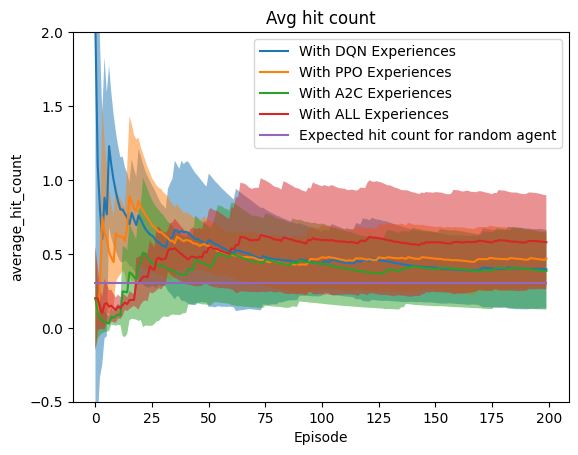

In [10]:
alls_3 = []
for alls_1 in alls[0]:
    t = 0
    list_1 = []
    for i in range(200):
        t += alls_1[i]
        list_1.append(t / (i + 1))
    alls_3.append(list_1)
    rewards = alls_3
mean_regret = np.mean(rewards, axis=0)
std_regret = np.std(rewards, axis=0)

upper_bound = mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))
lower_bound = mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))

fig, ax = plt.subplots()
ax.plot(mean_regret, label="With DQN Experiences")
ax.fill_between(np.arange(len(mean_regret)), lower_bound, upper_bound, alpha=0.5)

alls_3 = []
for alls_1 in alls[1]:
    t = 0
    list_1 = []
    for i in range(200):
        t += alls_1[i]
        list_1.append(t / (i + 1))
    alls_3.append(list_1)
    rewards = alls_3
mean_regret = np.mean(rewards, axis=0)
std_regret = np.std(rewards, axis=0)

upper_bound = mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))
lower_bound = mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))


ax.plot(mean_regret, label="With PPO Experiences")
ax.fill_between(np.arange(len(mean_regret)), lower_bound, upper_bound, alpha=0.5)


ax.set_title(f"Avg hit count")
ax.set_xlabel("Episode")
ax.set_ylabel("average_hit_count")
alls_3 = []
for alls_1 in alls[2]:
    t = 0
    list_1 = []
    for i in range(200):
        t += alls_1[i]
        list_1.append(t / (i + 1))
    alls_3.append(list_1)
    rewards = alls_3
mean_regret = np.mean(rewards, axis=0)
std_regret = np.std(rewards, axis=0)

upper_bound = mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))
lower_bound = mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))


ax.plot(mean_regret, label="With A2C Experiences")
ax.fill_between(np.arange(len(mean_regret)), lower_bound, upper_bound, alpha=0.5)


ax.set_title(f"Avg hit count")
ax.set_xlabel("Episode")
ax.set_ylabel("average_hit_count")
alls_3 = []
for alls_1 in alls[3]:
    t = 0
    list_1 = []
    for i in range(200):
        t += alls_1[i]
        list_1.append(t / (i + 1))
    alls_3.append(list_1)
    rewards = alls_3
mean_regret = np.mean(rewards, axis=0)
std_regret = np.std(rewards, axis=0)

upper_bound = mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))
lower_bound = mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))


ax.plot(mean_regret, label="With ALL Experiences")
ax.fill_between(np.arange(len(mean_regret)), lower_bound, upper_bound, alpha=0.5)


ax.set_title(f"Avg hit count")
ax.set_xlabel("Episode")
ax.set_ylabel("average_hit_count")
ax.plot([0.304 for i in range(200)], label="Expected hit count for random agent")
ax.set_ylim([-0.5, 2])
plt.legend()

plt.show()